# Token Benchmark Example Analysis
The following is an example of the analysis that can be done on individual responses that are saved when running `token_benchmark_ray.py` with the flag `--results-dir` which enables the saving of all responses.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [92]:
def get_final_metrics_df(valid_df):
    final_df = pd.DataFrame()
    final_df["number_input_tokens"] = valid_df["number_input_tokens"]
    final_df["number_output_tokens"] = valid_df["number_output_tokens"]
    final_df["number_total_tokens"]  = valid_df["number_total_tokens"]
    final_df["concurrent_user"] = valid_df["concurrent_user"]
    
    # server metrics
    final_df["ttft_server_s"] = valid_df["ttft_server_s"]
    final_df["end_to_end_latency_server_s"] = valid_df["end_to_end_latency_server_s"]
    final_df["generation_throughput_server"] = valid_df["request_output_throughput_server_token_per_s"]
    
    # client metrics
    final_df["ttft_s"] = valid_df["ttft_s"]
    final_df["end_to_end_latency_s"] = valid_df["end_to_end_latency_s"]
    final_df["generation_throughput"] = valid_df["request_output_throughput_token_per_s"]
    return final_df

# Metrics across concurrent workers

In [2]:
# num_current_users = [1,4,8,16]
mode='stream'
num_current_users = [1]

In [3]:
# path to the individual responses json file
df = pd.DataFrame()
for concurrent_user in num_current_users:
    df_user = pd.read_json(f'../data/results/llmperf/COE-llama-2-7b-chat-hf_1024_1024_{concurrent_user}_{mode}_individual_responses.json')
    # df_user = pd.read_json(f'../data/results/llmperf/COE-llama-2-7b-chat-hf_150_150_{concurrent_user}_{mode}_individual_responses.json')
    # df_user = pd.read_json(f'sambanova-Llama-2-7b-chat_150_150_{concurrent_user}_individual_responses.json')
    df_user['concurrent_user'] = concurrent_user
    df = pd.concat([df,df_user])

In [6]:
valid_df = df[(df["error_code"] != "")]
final_df = get_final_metrics_df(valid_df)

Text(0.5, 1.0, 'Number of output Tokens vs. Throughput')

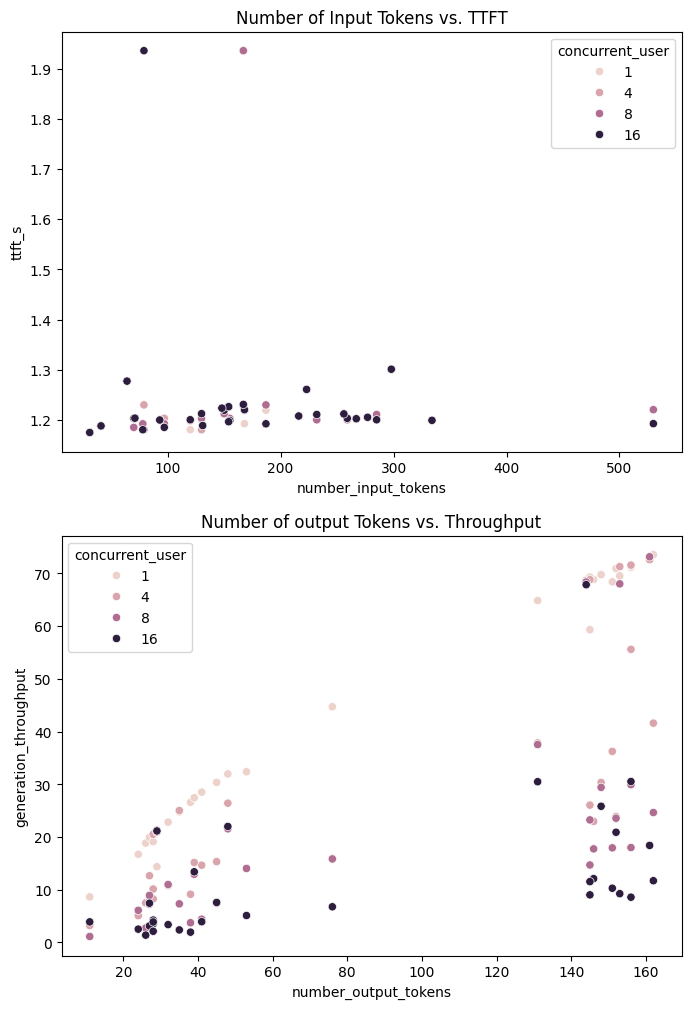

In [ ]:
fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(8,12))
sns.scatterplot(data=final_df, x="number_input_tokens", y="ttft_s", hue="concurrent_user", ax=ax[0]).set_title("Number of Input Tokens vs. TTFT")
sns.scatterplot(data=final_df, x="number_output_tokens", y="generation_throughput", hue="concurrent_user", ax=ax[1]).set_title("Number of output Tokens vs. Throughput")

<AxesSubplot: xlabel='generation_throughput'>

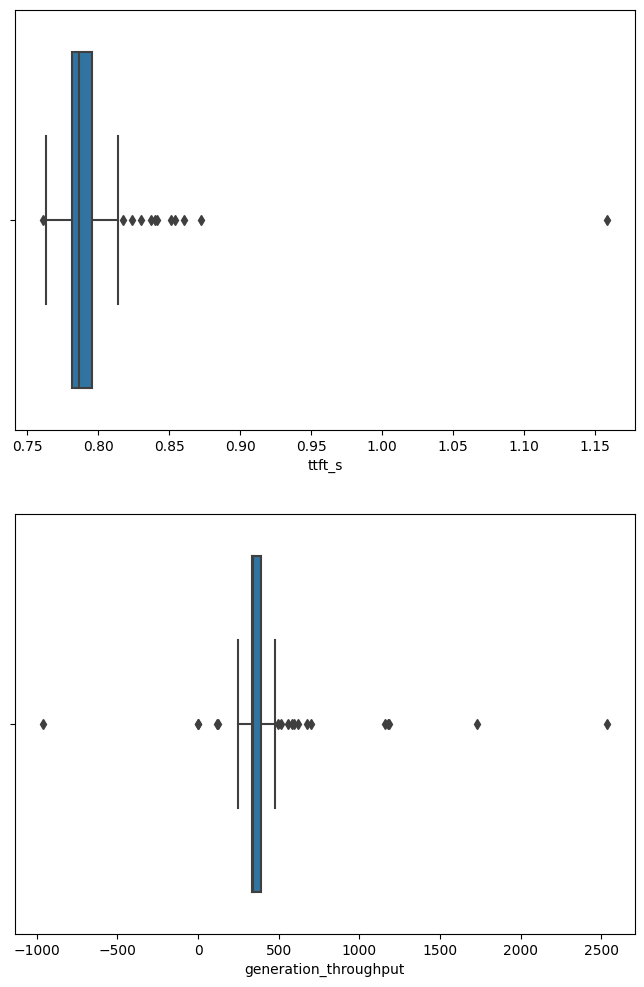

In [8]:
fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(8,12))
sns.boxplot(data=final_df, x="ttft_s", hue="concurrent_user", ax=ax[0])
sns.boxplot(data=final_df, x="generation_throughput", hue="concurrent_user", ax=ax[1])


# Server vs client metrics

In [93]:
concurrent_user = 1
mode = 'stream'

In [94]:
df = pd.read_json(f'../data/results/llmperf/COE-llama-2-7b-chat-hf_1024_1024_{concurrent_user}_{mode}_individual_responses.json')
df['concurrent_user'] = concurrent_user

In [95]:
valid_df = df[(df["error_code"] != "")]
final_df = get_final_metrics_df(valid_df)

In [99]:
df_server = final_df[['ttft_server_s','number_input_tokens', 'number_total_tokens', 'generation_throughput_server','number_output_tokens', 'end_to_end_latency_server_s']].copy()
df_server = df_server.rename(columns = {'ttft_server_s': 'ttft', 'generation_throughput_server': 'generation_throughput', 'end_to_end_latency_server_s': 'e2e_latency'})
df_server['type'] = 'Server side'               

df_client = final_df[['ttft_s','number_input_tokens', 'number_total_tokens', 'generation_throughput','number_output_tokens', 'end_to_end_latency_s']].copy()
df_client = df_client.rename(columns = {'ttft_s': 'ttft', 'end_to_end_latency_s': 'e2e_latency'})
df_client['type'] = 'Client side'               

df_ttft_throughput_latency = pd.concat([df_server, df_client], ignore_index=True)

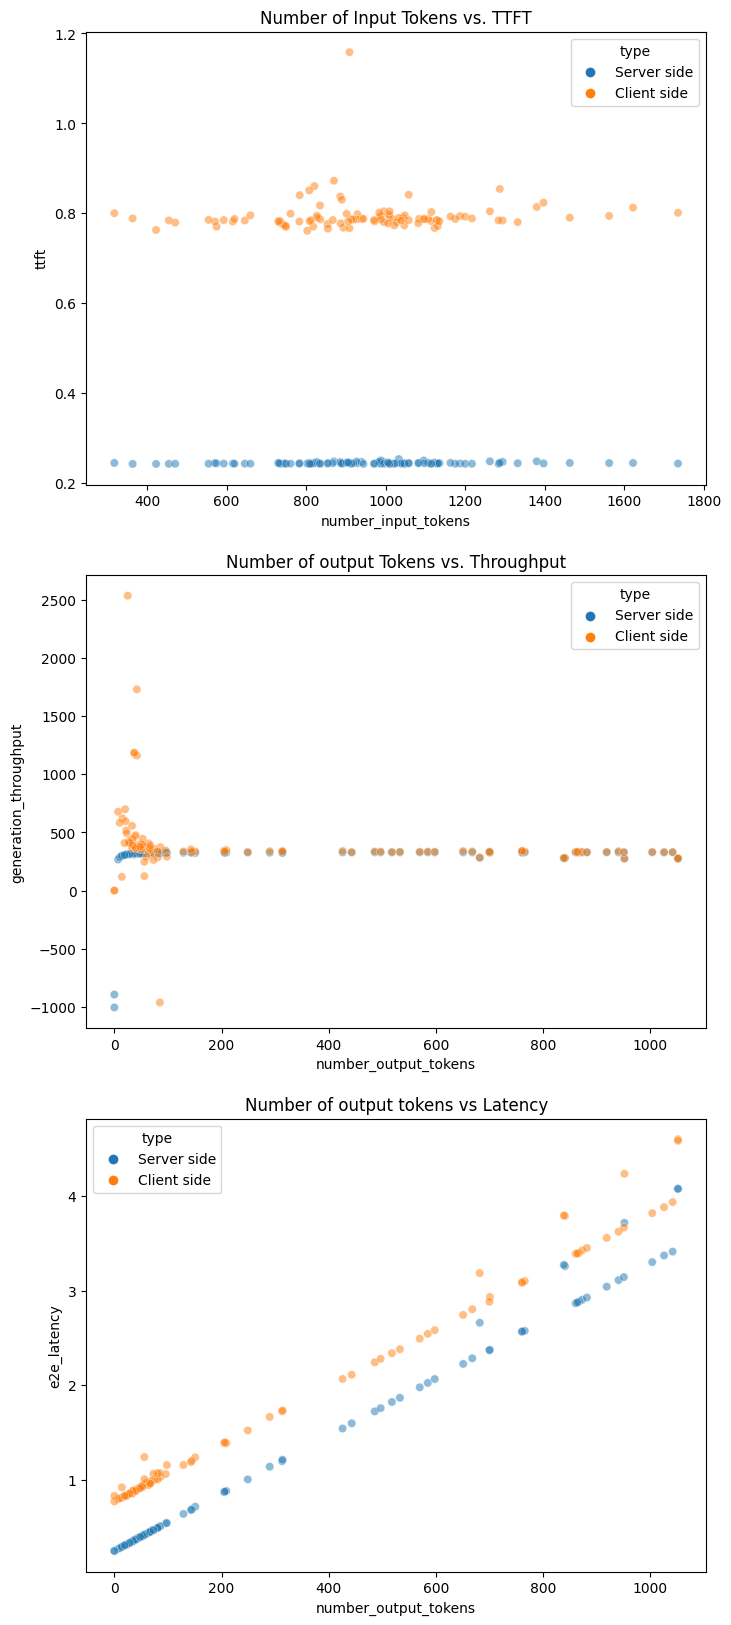

In [104]:
fig,ax = plt.subplots(nrows=3,ncols=1,figsize=(8,20))
sns.scatterplot(data=df_ttft_throughput_latency, x="number_input_tokens", y="ttft", hue="type", ax=ax[0], alpha=0.5).set_title("Number of Input Tokens vs. TTFT")
sns.scatterplot(data=df_ttft_throughput_latency, x="number_output_tokens", y="generation_throughput", hue="type", ax=ax[1], alpha=0.5).set_title("Number of output Tokens vs. Throughput");
sns.scatterplot(data=df_ttft_throughput_latency, x="number_output_tokens", y="e2e_latency", hue="type", ax=ax[2], alpha=0.5).set_title("Number of output tokens vs Latency");

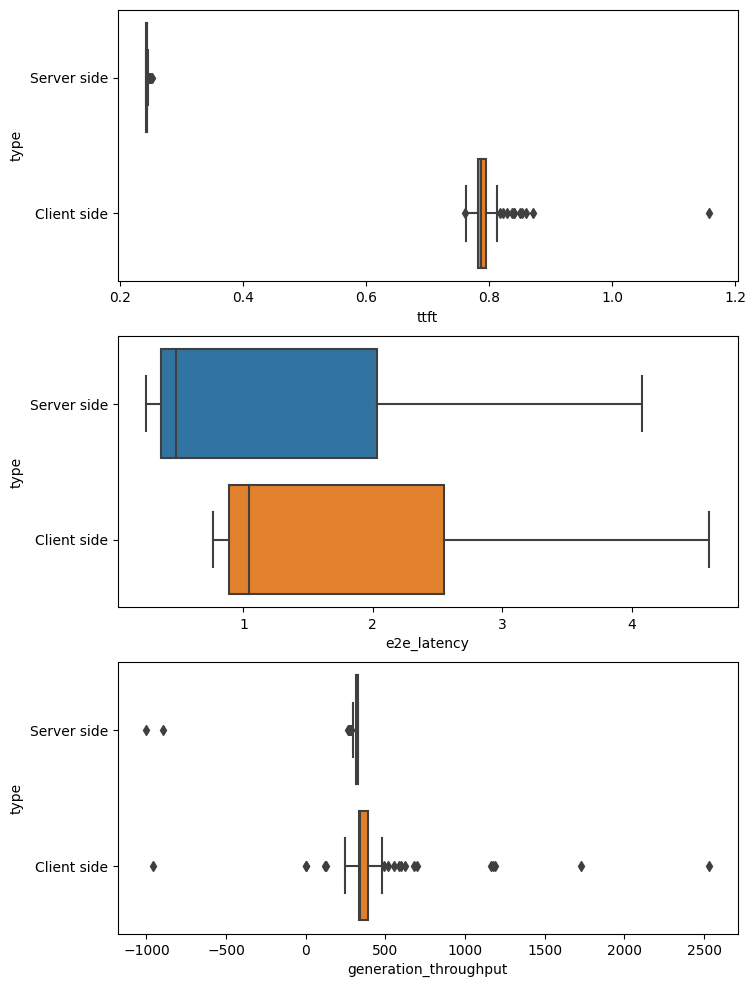

In [69]:
fig,ax = plt.subplots(nrows=3,ncols=1,figsize=(8,12))
sns.boxplot(data=df_ttft_throughput_latency, x="ttft", y="type", ax=ax[0])
sns.boxplot(data=df_ttft_throughput_latency, x="e2e_latency", y="type", ax=ax[1])
sns.boxplot(data=df_ttft_throughput_latency, x="generation_throughput", y="type", ax=ax[2]);